In [28]:
%run setup.py
import tqdm

In [3]:
koi = pd.read_csv('../data/koi_dsct.csv')
toi = pd.read_csv('../data/toi.csv')

In [4]:
koi

,Unnamed: 0,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,dsct
0,0,3964109,K00393.01,Kepler-544 b,CONFIRMED,Done,16/8/18,CANDIDATE,1.000,0,...,0.48,0.63,0.57,0.000,1.300,0.500,0.510,0.500,0.530,True
1,1,9111849,K02042.01,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,0.994,0,...,0.19,0.31,0.13,0.150,0.120,-0.200,0.130,0.250,0.130,True
2,2,9845898,K02423.01,Kepler-1233 b,CONFIRMED,Done,16/8/18,CANDIDATE,1.000,0,...,1.10,0.60,0.85,0.110,0.700,-0.700,1.100,0.700,1.100,True
3,3,5202905,K01932.01,Kepler-340 c,CONFIRMED,Done,16/8/18,CANDIDATE,0.944,0,...,0.22,0.32,0.23,-0.110,0.260,0.430,0.230,0.440,0.220,True
4,4,5202905,K01932.02,Kepler-340 b,CONFIRMED,Done,16/8/18,CANDIDATE,0.636,0,...,0.26,0.39,0.39,0.400,0.440,-0.150,0.250,0.430,0.400,True
5,5,6116172,K06142.02,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,NaN,0,...,0.24,7.90,2.70,-8.000,2.100,-0.580,0.230,8.000,2.100,True
6,6,6116172,K06142.01,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,NaN,0,...,0.24,7.90,2.70,-8.000,2.100,-0.580,0.230,8.000,2.100,True
7,7,6116172,K06142.02,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,NaN,0,...,0.24,7.90,2.70,-8.000,2.100,-0.580,0.230,8.000,2.100,True
8,8,11013201,K00972.03,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,0.632,0,...,1.30,5.20,1.50,-3.210,0.810,4.300,1.100,5.400,1.300,True
9,9,11013201,K00972.02,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,0.000,0,...,1.70,3.90,1.70,-4.700,1.200,3.000,1.800,5.600,1.700,True


In [5]:
from astropy.stats import BoxLeastSquares

def high_pass(t, y, width=3.):
    y_low = gaussian_filter(y, width)
    return y - y_low

def get_kepler_lc(kic_id):
    file = glob.glob(f'../data/lightcurves/Kepler/*{kic_id}.txt')[0]
    t, y = np.loadtxt(file, usecols=(0,1)).T
    return t, y
    
def preprocess_lc(t, y):
    y = high_pass(t, y)
    lc = lk.LightCurve(t, y).remove_outliers()
    return lc.time, lc.flux

In [32]:
ii = 3
t, y =preprocess_lc(*get_kepler_lc(koi.iloc[ii].kepid))
# t, y = preprocess_lc(lc.time, lc.flux)

koi_period = koi.iloc[ii].koi_period
koi_period_err = koi.iloc[ii].koi_period_err1
koi_eccen = koi.iloc[ii].koi_eccen

print(koi.iloc[ii].kepid)

5202905


In [33]:
koi_period

22.8245144

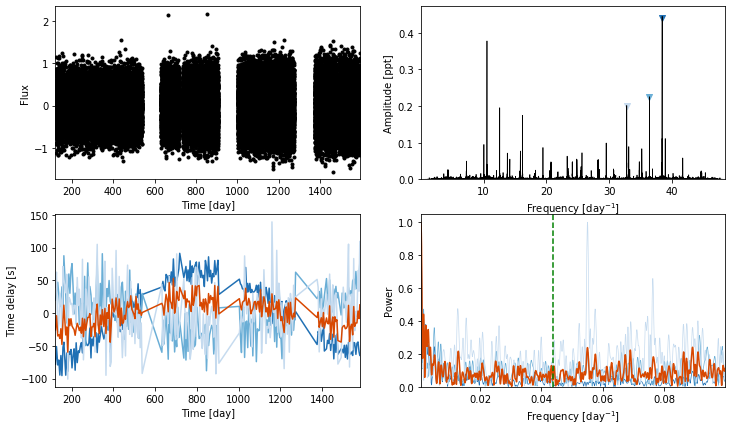

In [37]:
ms = Maelstrom(t, y, max_peaks=3, fmin=5, fmax=41)
ax = ms.first_look(segment_size=5);
ax[3].axvline(1./koi_period, c='g', linestyle='dashed')

In [38]:
pg = ms.period_search()
res = pg.fit([koi_period])

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


In [39]:
[np.exp(r[0][1]['logasini']) for r in res]

[4.881344371613768, 8.464681404809975, 9.908217360274714]

In [40]:
time, flux = ms.time, ms.flux
freq, weight = ms.freq, ms.get_weights(norm=False)

In [41]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

with pm.Model() as model:
#     logP = pm.Normal("logP", mu=np.log(koi_period), sd=0.1,
#                                       testval=np.log(koi_period))
    period = koi_period#pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=np.log(np.std(flux)))
#     asini = pm.Lognormal("asini", mu=np.log(np.ones(len(freq))), sigma=np.ones_like(freq), shape=len(freq), testval=np.log(np.ones(len(freq))))
#     asini = pm.HalfNormal("asini", tau=0.01*np.ones(len(freq)), shape=len(freq))
#     asini = pm.Uniform('asini', lower=0, upper=100, testval=1e-5, shape=len(freq))
    asini = pm.Bound(pm.Flat, lower=0)("asini", shape=len(freq), testval=res[0][0][1]['logasini'] + np.zeros(len(freq)))

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.000)   

    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    
    if koi_eccen == 0:
        omega = 0.
        # Eccentricity
        eccen = 0.
        psi = -tt.sin(M)
    else:
        omega = xo.distributions.Angle("omega")
        eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
        # True anom
        kepler_op = xo.theano_ops.kepler.KeplerOp()
        sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))

        factor = 1.0 - tt.square(eccen)
        factor /= 1.0 + eccen * cosf
        psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor)[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_mean_amp = np.log(weight)
    logamp = pm.Normal("logamp", mu=log_mean_amp, sd=1.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
    
    full_lc = lc_model + mean
    pm.Normal("obs", mu=full_lc, sd=tt.exp(logs_lc), observed=flux)
    
    
#     # GP parameters
#     logw0 = pm.Bound(pm.Normal,
#                          lower=np.log(2*np.pi/100.0),
#                          upper=np.log(2*np.pi/1))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                     testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=100)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
#     pm.Potential("obs", gp.log_likelihood(flux - full_lc))

In [42]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "asini_interval__"]]
    
    map_params = xo.optimize(start=None, vars=[model['mean']])
    map_params = xo.optimize(start=map_params, vars=[model['logs_lc']])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
#     map_params = xo.optimize(start=None, vars=[model['logP']])
    map_params = xo.optimize(start=map_params, vars=[model['phase'], model['logamp']])
    if not koi_eccen == 0:
        map_params = xo.optimize(start=map_params, vars=[model['eccen'], model['omega']])
    map_params = xo.optimize(start=map_params, vars=[model["phi"]])
    map_params = xo.optimize(start=map_params, vars=[model["lognu"]])
    map_params = xo.optimize(start=map_params)
    
    map_params = xo.optimize(start=map_params, vars=[model['asini']])
    map_params = xo.optimize(start=map_params)

optimizing logp for variables: [mean]
5it [00:00, 81.69it/s, logp=-7.915178e+04] 
message: Optimization terminated successfully.
logp: -79151.77814413288 -> -79151.77628791558
optimizing logp for variables: [logs_lc]
73it [00:00, 126.52it/s, logp=-5.865322e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -79151.77628791558 -> -58653.22465816546
optimizing logp for variables: [logamp, phase]
126it [00:01, 84.51it/s, logp=-3.496954e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -58653.22465816546 -> -34969.53923333989
optimizing logp for variables: [phi]
53it [00:00, 76.05it/s, logp=-3.494899e+04]
message: Optimization terminated successfully.
logp: -34969.53923333989 -> -34948.98752222851
optimizing logp for variables: [lognu]
86it [00:01, 79.68it/s, logp=-3.494899e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -34948.98752222851 -> -34948.98735866928
optimizing logp for variables: [lo

In [43]:
map_params

{'phi_angle__': array([ 3.73555169, -2.45878215]),
 'logs_lc': array(-1.46707617),
 'asini_lowerbound__': array([0.54379411, 1.57043531, 1.74936854]),
 'mean': array(-2.87709182e-05),
 'lognu': array([3.64800369, 3.59380084, 3.48939368]),
 'phase_angle__': array([[ 1.68246406,  2.93004085, -4.44630443],
        [-4.14358456, -3.37858436,  0.4799968 ]]),
 'logamp': array([-0.8192672 , -1.49422436, -1.60661348]),
 'phi': array(2.15292231),
 'asini': array([1.72252995, 4.80874105, 5.75097   ]),
 'nu': array([38.39793546, 36.37205783, 32.76607501]),
 'phase': array([ 2.75588963,  2.42717508, -1.46325869])}

In [44]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        step=xo.get_dense_nuts_step(target_accept=0.9),
        start=map_params
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logamp, phase, lognu, mean, asini, logs_lc, phi]
Sampling 4 chains: 100%|██████████| 8000/8000 [30:52<00:00,  4.89draws/s]  


In [45]:
np.median(trace['asini'], axis=0), np.std(trace['asini'], axis=0)

(array([1.14880394, 2.8834443 , 3.64738292]),
 array([1.00399912, 2.42789588, 2.91632818]))

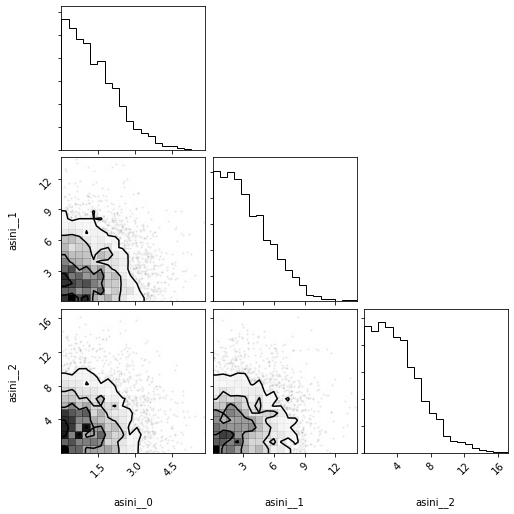

In [46]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['asini']));

# Uniform

In [20]:
np.median(trace['asini'], axis=0), np.std(trace['asini'], axis=0)

(array([45.89876044]), array([28.06608385]))

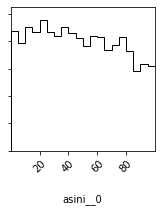

In [21]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['asini']));

# Half normal

In [26]:
np.median(trace['asini'], axis=0), np.std(trace['asini'], axis=0)

(array([6.54960795]), array([6.0015535]))

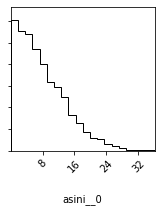

In [27]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['asini']));

pls dont read below me

In [116]:
import pickle # python3

with open(f'results/{koi.iloc[ii].kepid}_new_model.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [63]:
print('hi')

hi


UNIFORM PRIOR:

In [63]:
np.median(trace['asini'], axis=0), np.std(trace['asini'], axis=0)

(array([1.17351951, 2.82633558, 3.10381713, 3.25305047, 6.20564226]),
 array([0.97635272, 2.24190642, 2.51197599, 3.2279576 , 5.42522285]))

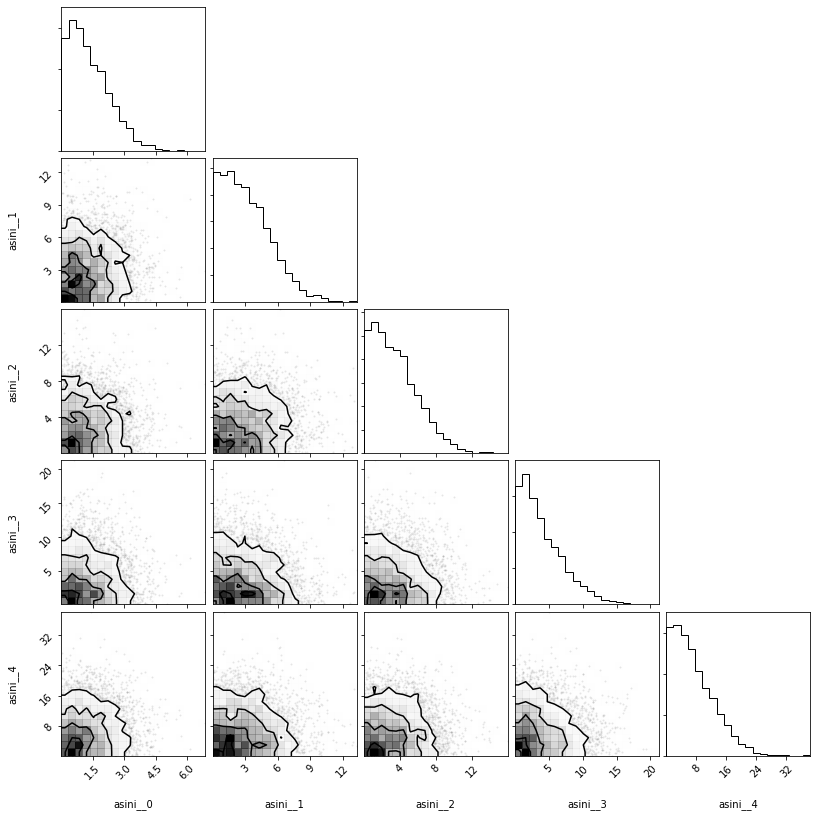

In [64]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['asini']));

In [47]:
mf = mass_function(koi.iloc[ii].koi_period*u.day, np.median(trace['asini'], axis=0).min() * u.s)
mass = (mf.to(u.M_jup))**(1/3) * ((koi.iloc[ii].koi_smass*u.M_sun).to(u.M_jup))**(2/3)
mass

<Quantity 96.19409307 jupiterMass>

In [45]:
row.koi_smass

1.421

In [21]:
mf = mass_function(koi.iloc[ii].koi_period*u.day,trace['asini'] * u.s)
mass = (mf.to(u.M_jup))**(1/3) * ((koi.iloc[ii].koi_smass*u.M_sun).to(u.M_jup))**(2/3)
mass

<Quantity [[ 6.00787054,  5.97714541,  8.85193295, 13.63894966,
            12.33870249],
           [30.41108375, 24.08067167, 16.44439858, 16.99368704,
            17.5889056 ],
           [24.50529666, 22.1674639 , 18.10165143,  7.58290357,
            11.79777893],
           ...,
           [ 6.79907129, 11.46251576, 26.68223664,  1.65979652,
            25.95352982],
           [ 4.78454148,  6.68802929,  5.383106  , 43.38631213,
             2.13799856],
           [ 2.25669616, 20.34600387, 35.85969707,  0.95033186,
             0.40647634]] jupiterMass>

In [47]:
np.median(mass, axis=0), np.std(mass, axis=0)

(<Quantity [ 9.2876213 , 11.50799263, 11.2129879 , 11.36834245, 11.40989439] jupiterMass>,
 <Quantity [ 8.7667919 ,  9.86799838, 10.13086185, 10.08097125, 10.03875112] jupiterMass>)

In [42]:
row = koi.iloc[ii]
row.koi_time0bk % row.koi_period / row.koi_period

0.3295291837621746